# Cat vs. Dog Image Classification With `ktrain`

We will use `ktrain` to fine-tune a `ResNet50` network pretrained on ImageNet for the Cats vs. Dogs dataset.  This dataset is a subset of 2000 JPG imgages from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. 

**NOTE:** Don't forget to set this notebook to use a GPU. go to `Runtime->Change runtime type` and select `GPU`.

Let's begin by installing the `ktrain` library and importing some modules that we'll need. If you see an `ERROR` related to the `gast` package, you can ignore it.

In [ ]:
!pip3 install -q ktrain

     |████████████████████████████████| 25.2MB 136kB/s 
     |████████████████████████████████| 421.8MB 35kB/s 
     |████████████████████████████████| 983kB 51.2MB/s 
     |████████████████████████████████| 245kB 58.4MB/s 
     |████████████████████████████████| 573kB 55.0MB/s 
     |████████████████████████████████| 471kB 51.6MB/s 
     |████████████████████████████████| 450kB 50.5MB/s 
     |████████████████████████████████| 3.9MB 57.0MB/s 
     |████████████████████████████████| 1.0MB 46.6MB/s 
     |████████████████████████████████| 3.7MB 54.8MB/s 
     |████████████████████████████████| 890kB 53.2MB/s 
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [ ]:
import ktrain
from ktrain import vision as vis

## Download the Data and Extract to `/tmp`

We will download the data and unzip it to the `/tmp` folder.

There will be two folders:
1. `train` contains the training images
2. `validation` ocntains the validation images



In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-24 22:18:12--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 2a00:1450:4013:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  82.7MB/s    in 0.8s    

2020-04-24 22:18:13 (82.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
!ls /tmp/cats_and_dogs_filtered

train  validation  vectorize.py


Let's peruse the images using `show_random_images`.

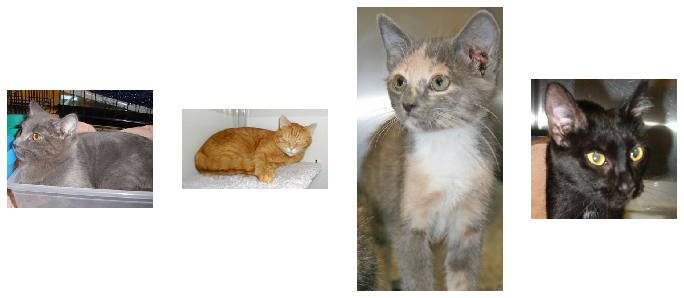

In [ ]:
# some random images from the CATS folder
vis.show_random_images('/tmp/cats_and_dogs_filtered/train/cats')

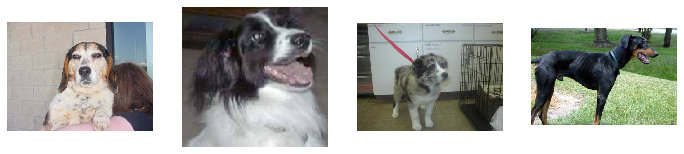

In [ ]:
# some random images from the DOGS folder
vis.show_random_images('/tmp/cats_and_dogs_filtered/train/dogs')

## STEP 1: Load and Preprocess the Images

We will use the `images_from_folder` function to load the images as `DirectoryIterator` objects.  A `Preprocessor` instance is also returned as the third value, which we'll use later to preprocess raw images into the format expected by the model.

In [ ]:
(trn, val, preproc) = vis.images_from_folder(
                                              datadir='/tmp/cats_and_dogs_filtered',
                                              data_aug = vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'validation'])

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## STEP 2: Create the Model and Wrap in `Learner`

In [ ]:
model = vis.image_classifier('pretrained_resnet50', trn, val, freeze_layers=15)
learner = ktrain.get_learner(model=model, train_data=trn, val_data=val, 
                             workers=8, use_multiprocessing=False, batch_size=64)

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
94773248/94765736 [==============================] - 3s 0us/step
pretrained_resnet50 model created.


## STEP 3: Estimate Learning Rate

Let's simulate the training and gradually increase the learning rate until it diverges.  We will select a learning rate associated with a falling loss.

In [ ]:
learner.lr_find(max_epochs=3)

simulating training for different learning rates... this may take a few moments...
Train for 31 steps
Epoch 1/3
31/31 [==============================] - 44s 1s/step - loss: 2.0058 - accuracy: 0.5015
Epoch 2/3
31/31 [==============================] - 41s 1s/step - loss: 3.2169 - accuracy: 0.7986
Epoch 3/3
 1/31 [..............................] - ETA: 7:23 - loss: 142.2393 - accuracy: 0.5156

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


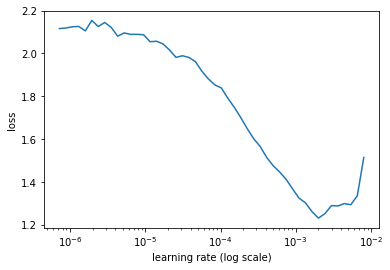

In [ ]:
learner.lr_plot()

## STEP 4: Train the Model

We will only train for a single epoch for demonstration purposes.   With only one pass through the dataset our validaton accuracy is already more than 97%.

In [ ]:
learner.fit_onecycle(1e-4, 1)



begin training using onecycle policy with max lr of 0.0001...
Train for 32 steps, validate for 32 steps
32/32 [==============================] - 49s 2s/step - loss: 0.9459 - accuracy: 0.7505 - val_loss: 0.0994 - val_accuracy: 0.9710


## Make Predictions

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)


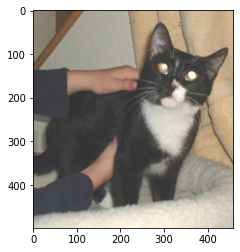

In [ ]:
vis.show_image('/tmp/cats_and_dogs_filtered/validation/cats/cat.2000.jpg')

In [ ]:
predictor.predict_filename('/tmp/cats_and_dogs_filtered/validation/cats/cat.2000.jpg')

['cats']

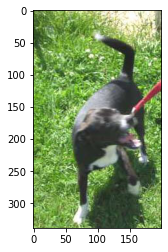

In [ ]:
vis.show_image('/tmp/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg')

In [ ]:
predictor.predict_filename('/tmp/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg')

['dogs']

In [ ]:
# show predicted class "probabilities"
predictor.predict_filename('/tmp/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg', return_proba=True)

array([[0.00203596, 0.997964  ]], dtype=float32)

In [ ]:
predictor.get_classes()

['cats', 'dogs']

In [ ]:
# save predictor (both model and preproc)
predictor.save('/tmp/catdog_predictor')

In [ ]:
# reload predictor
predictor = ktrain.load_predictor('/tmp/catdog_predictor')

In [ ]:
# still works
predictor.predict_filename('/tmp/cats_and_dogs_filtered/validation/cats/cat.2000.jpg')

['cats']

## Clean Up

Run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)